In [234]:
# rsync -av -e 'ssh -o ProxyCommand="ssh -q -W %h:%p s2016765@ssh.inf.ed.ac.uk"' s2016765@mlp.inf.ed.ac.uk:/home/s2016765/final_project/experiments/resnet50_aircraft_224_224 experiments/
# for file in ~/final_project/exp_scripts/*.out; do echo "File: $file"; tail -n 2 "$file"; echo; echo; done

import os
import random

import torch
import timm
from PIL import Image
import cv2
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50, vit_b_16, ViT_B_16_Weights, ResNet50_Weights

import torch.nn.functional as F
import cv2

from cub2011 import Cub2011

In [3]:
# Download Bird dataset into data/ folder by setting download=True. 
# The 'train_data' variable won't be used later in the code, it's just there to download the dataset.

train_data = Cub2011(root='data', train=True, download=True)

100%|████████████████████████████████████████████████████████████| 1150585339/1150585339 [04:53<00:00, 3924448.78it/s]


# Accuracy and loss

In [4]:
epoch_dict = {'resnet50_im_224': 100,
              'resnet50_im21_224': 100, 
              'resnet50_base_224': 94,
              'resnet50_im_100': 85, 
              'resnet50_im21_100': 96,
              'resnet50_base_100': 30,
              
              'vitb16_im_224': 64, 
              'vitb16_im21_224': 78, 
              'vitb16_base_224': 74,  
              'vitb16_im_100': 42, 
              'vitb16_im21_100': 68, 
              'vitb16_base_100': 84
 }

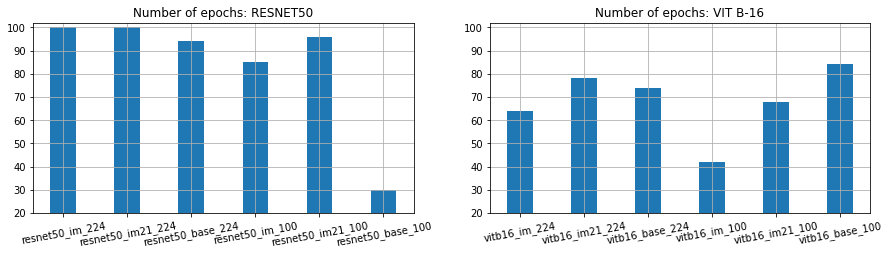

In [106]:
# Create two subplots
plt.figure(figsize=(15, 3.5))  # Adjust the figure size as needed
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.grid(True)
plt.bar(['resnet50_im_224','resnet50_im21_224','resnet50_base_224','resnet50_im_100', 'resnet50_im21_100','resnet50_base_100'], [100,100,94,85,96,30], 0.4)
plt.xticks(['resnet50_im_224','resnet50_im21_224','resnet50_base_224','resnet50_im_100', 'resnet50_im21_100','resnet50_base_100'], ['resnet50_im_224','resnet50_im21_224','resnet50_base_224','resnet50_im_100', 'resnet50_im21_100','resnet50_base_100'], rotation=10)
plt.ylim(20, 102)
plt.title('Number of epochs: RESNET50')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.bar(['vitb16_im_224','vitb16_im21_224','vitb16_base_224','vitb16_im_100','vitb16_im21_100','vitb16_base_100'], [64,78,74,42,68,84], 0.4)
plt.title('Number of epochs: VIT B-16')
plt.xticks(['vitb16_im_224','vitb16_im21_224','vitb16_base_224','vitb16_im_100','vitb16_im21_100','vitb16_base_100'], ['vitb16_im_224','vitb16_im21_224','vitb16_base_224','vitb16_im_100','vitb16_im21_100','vitb16_base_100'], rotation=10)
plt.ylim(20, 102)
plt.grid(True)

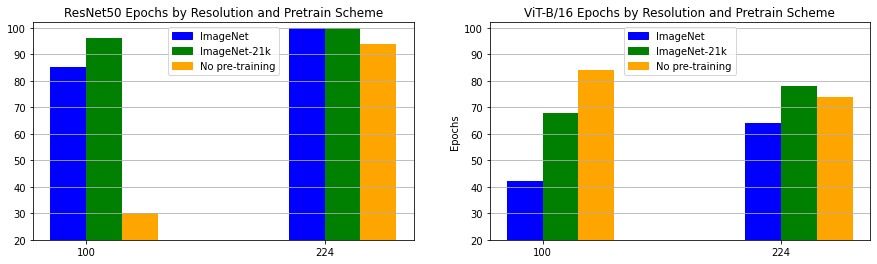

In [314]:
from matplotlib.patches import Patch

# Define colors for different pretrain schemes
colors = {'im': 'blue', 'im21': 'green', 'base': 'orange'}

# Define labels for different pretrain schemes
labels = {'im': 'ImageNet', 'im21': 'ImageNet-21k', 'base': 'Baseline'}

legend_mapping = {'ImageNet': 'blue', 'ImageNet-21k': 'green', 'No pre-training': 'orange'}

# Create a legend with colored patches
legend_patches = [Patch(color=color, label=label) for label, color in legend_mapping.items()]

resnet50_data = {'100':{'im': 85, 
                      'im21': 96,
                      'base': 30},
    '224': {'im': 100,
                          'im21': 100, 
                          'base': 94,
                        }
              
                }
            
vitb16_data = {'100':{'im': 42, 
                      'im21': 68,
                      'base': 84},
               '224': {'im': 64,
                          'im21': 78, 
                          'base': 74,
                        }
              
                }

# Define resolutions and pretrain schemes
resolutions = list(resnet50_data.keys())
pretrain_schemes = list(resnet50_data['224'].keys())

# Initialize figure and axes for ResNet50
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
ax1.set_title('ResNet50 Epochs by Resolution and Pretrain Scheme')

# Define width of each bar
bar_width = 0.15

# Iterate over resolutions
for i, (resolution, resnet50_epochs) in enumerate(resnet50_data.items()):
    # Calculate x positions for resnet50 bars
    x = [i + j * bar_width for j in range(len(pretrain_schemes))]
    # Plot resnet50 bars
    ax1.bar(x, list(resnet50_epochs.values()), bar_width, color=colors.values())

# Set x-axis labels and ticks
ax1.set_xticks([i + bar_width / 2 for i in range(len(resolutions))])
ax1.set_xticklabels(resolutions)

ax1.grid(axis='y')

# Plot something to display the legend
ax1.legend(handles=legend_patches, loc='upper center')  # Use the custom legend patches

ax1.set_ylim(20,102)

# Initialize figure and axes for ViT-B/16
ax2.set_title('ViT-B/16 Epochs by Resolution and Pretrain Scheme')

# Iterate over resolutions
for i, (resolution, vitb16_epochs) in enumerate(vitb16_data.items()):
    # Calculate x positions for vitb16 bars
    x = [i + j * bar_width for j in range(len(pretrain_schemes))]
    # Plot vitb16 bars
    ax2.bar(x, list(vitb16_epochs.values()), bar_width, color=colors.values())

# Set x-axis labels and ticks
ax2.set_xticks([i + bar_width / 2 for i in range(len(resolutions))])
ax2.set_xticklabels(resolutions)

ax2.grid(axis='y')

# Set y-axis label
ax2.set_ylabel('Epochs')

ax2.set_ylim(20,102)

# Plot something to display the legend
ax2.legend(handles=legend_patches, loc='upper center')  # Use the custom legend patches

# Show plots
plt.show()

In [31]:
model_summary_dict = {
    'resnet50_im_224': 'experiments/resnet50_im_224/result_outputs/summary.csv',
    'resnet50_im21_224': 'experiments/resnet50_im21_224/result_outputs/summary.csv',
 'vitb16_im_224':'experiments/vitb16_im_224/result_outputs/summary.csv',
 'vitb16_im21_224':'experiments/vitb16_im21_224/result_outputs/summary.csv',
 'resnet50_base_224':'experiments/resnet50_base_224/result_outputs/new_summary.csv',
 'vitb16_base_224':'experiments/vitb16_base_224/result_outputs/new_summary.csv',
 'resnet50_im_100':'experiments/resnet50_im_100/result_outputs/new_summary.csv',
 'resnet50_im21_100':'experiments/resnet50_im21_100/result_outputs/new_summary.csv',
 'vitb16_im_100':'experiments/vitb16_im_100/result_outputs/new_summary.csv',
 'vitb16_im21_100':'experiments/vitb16_im21_100/result_outputs/new_summary.csv',
 'resnet50_base_100':'experiments/resnet50_base_100/result_outputs/new_summary.csv',
 'vitb16_base_100':'experiments/vitb16_base_100/result_outputs/new_summary.csv',
}

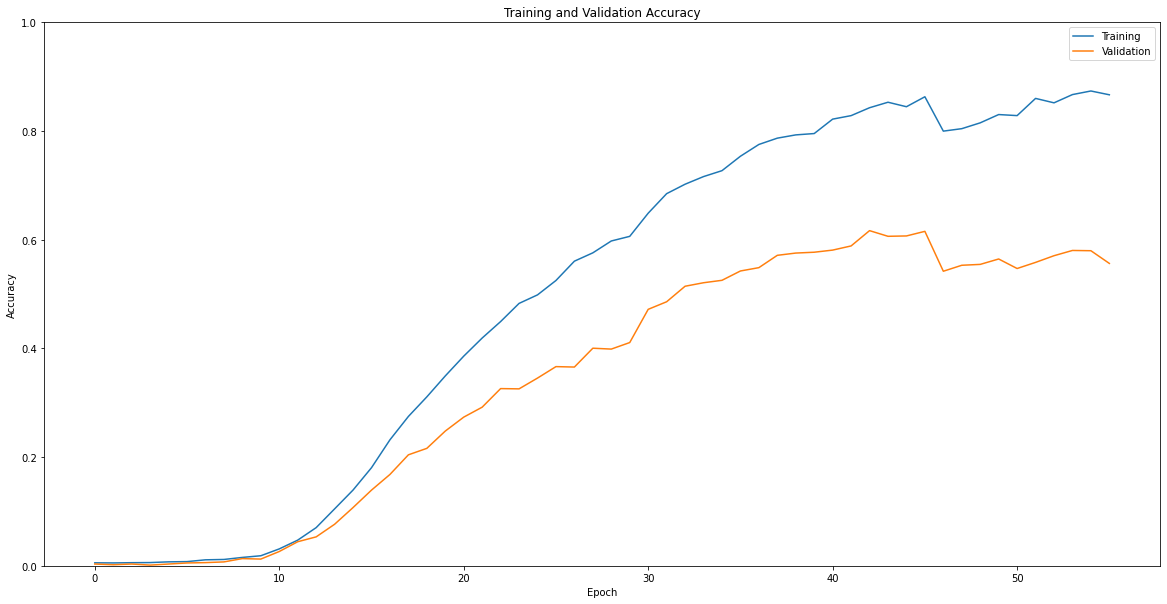

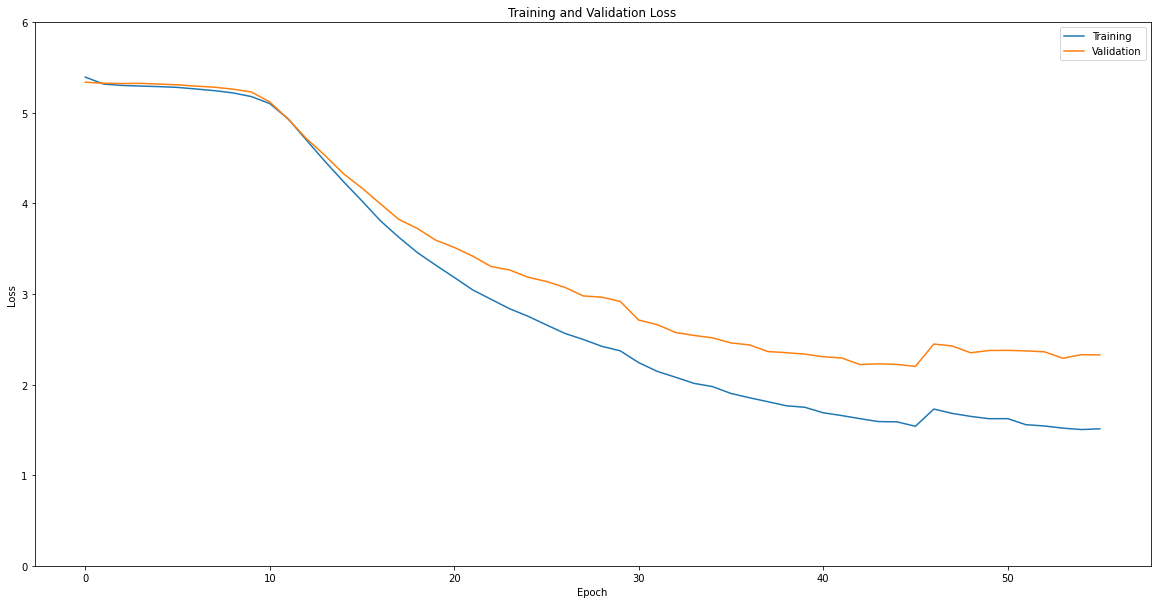

In [32]:
# Read the CSV file
df = pd.read_csv(model_summary_dict['vitb16_im21_224'])

# Plotting the training and validation accuracy
plt.figure(figsize=(20, 10))
plt.plot(df['train_acc'], label='Training')
plt.plot(df['val_acc'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('Training and Validation Accuracy')
plt.legend()
# plt.show()

# Plotting the training and validation loss
plt.figure(figsize=(20, 10))
plt.plot(df['train_loss'], label='Training')
plt.plot(df['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 6)
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# Image transformation testing

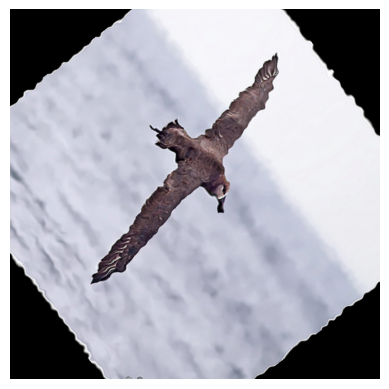

In [5]:
# Testing the effects of transformations

# Define transformations
transform = transforms.Compose([
    transforms.Resize((768, 768), interpolation=Image.BICUBIC),  # Resize to 224x224
    # transforms.CenterCrop(75),  # Crop to 224x224 at the center
    # transforms.Resize((512, 512), interpolation=Image.BICUBIC),
    # transforms.ElasticTransform(125.0),
    transforms.RandomRotation(180),
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Path to your image
image_path = "data/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0009_34.jpg"

# Load and apply transformations
image = Image.open(image_path)
transformed_tensor = transform(image)

# Reverse normalization and convert tensor to PIL image
reverse_normalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])
reverse_transform = transforms.Compose([transforms.Normalize((0, 0, 0), (1, 1, 1)), transforms.ToPILImage()])
transformed_image = reverse_transform(reverse_normalize(transformed_tensor))

# Display the transformed image
plt.imshow(transformed_image)
plt.axis('off')
plt.show()

# Retrieve model

The functions below can be used to retrieve the best model for the specified model: ['resnet50', 'vitb16'], pre-training scheme: ['im', 'im21', 'base'], and resolutions: [100, 224] 

In [33]:
def load_weights(model, state):
    for key in model.state_dict():
        if 'num_batches_tracked' in key:
            continue
        p = model.state_dict()[key]
        if 'model.module.' + key in state['network']:
            ip = state['network']['model.module.' + key]
            if p.shape == ip.shape:
                p.data.copy_(ip.data)  # Copy the data of parameters
            else:
                print(
                    'could not load layer: {}, mismatch shape {} ,{}'.format(key, (p.shape), (ip.shape)))
        else:
            print('could not load layer: {}, not in checkpoint'.format(key))
    return model

In [158]:
def get_model(model_name, pretrain_scheme, res, num_classes=None):
    directory = f'experiments/{model_name}_{pretrain_scheme}_{res}'
    # Get all file names in the directory
    file_names = os.listdir(directory)

    # Filter file names that start with 'train_model'
    filtered_file_names = [file_name for file_name in file_names if file_name.startswith('train_model')]
    model_path = os.path.join(directory, filtered_file_names[-1])
    print(f'Loading model from {model_path}')
    state = torch.load(model_path, map_location=torch.device('cpu'))
    if model_name == 'resnet50':
        model = resnet50()
        model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
        model = load_weights(model, state)
    elif model_name == 'vitb16':
        if pretrain_scheme in ['im', 'base']:
            model = vit_b_16()
            model.heads[0].out_features = num_classes
            model = load_weights(model, state)
        elif pretrain_scheme == 'im21':
            model_kwargs = dict(
            patch_size=16, embed_dim=768, depth=12, num_heads=12, qkv_bias=False)
            model = timm.models.vision_transformer._create_vision_transformer('vit_base_patch16_224_in21k',
                                                                            pretrained=False,
                                                                            num_classes=num_classes, **model_kwargs)
            model = load_weights(model, state)
    
    print(f'Loaded {model_name}_{pretrain_scheme}_{res}')
    return model

class_dict = {'birds': 200, 'aircraft': 100}

In [160]:
for model_name in ['resnet50', 'vitb16']:
    for pretrain_scheme in ['im', 'im21', 'base']:
        for res in ['224', '100']:
            if not (model_name == 'resnet50' and pretrain_scheme == 'im' and res == '224') and not (model_name == 'vitb16' and pretrain_scheme == 'base' and res == '100'):
                model = get_model(model_name, pretrain_scheme, res, class_dict['birds'])

['train_model_85.zip']
Loading model from experiments/resnet50_im_100/train_model_85.zip
Loaded resnet50_im_100
['train_model_latest.zip']
Loading model from experiments/resnet50_im21_224/train_model_latest.zip
Loaded resnet50_im21_224
['train_model_96.zip']
Loading model from experiments/resnet50_im21_100/train_model_96.zip
Loaded resnet50_im21_100
['train_model_94.zip']
Loading model from experiments/resnet50_base_224/train_model_94.zip
Loaded resnet50_base_224
['train_model_98.zip']
Loading model from experiments/resnet50_base_100/train_model_98.zip
Loaded resnet50_base_100
['train_model_latest']
Loading model from experiments/vitb16_im_224/train_model_latest
Loaded vitb16_im_224
['train_model_42']
Loading model from experiments/vitb16_im_100/train_model_42


No pretrained configuration specified for vit_base_patch16_224_in21k model. Using a default. Please add a config to the model pretrained_cfg registry or pass explicitly.


Loaded vitb16_im_100
['train_model_78']
Loading model from experiments/vitb16_im21_224/train_model_78


No pretrained configuration specified for vit_base_patch16_224_in21k model. Using a default. Please add a config to the model pretrained_cfg registry or pass explicitly.


Loaded vitb16_im21_224
['train_model_68']
Loading model from experiments/vitb16_im21_100/train_model_68
Loaded vitb16_im21_100
['train_model_74']
Loading model from experiments/vitb16_base_224/train_model_74
Loaded vitb16_base_224


# Gradient visualisation

In [35]:
class ResnetFeatureExtractor(torch.nn.Module):
    def __init__(self, model):
        super(ResnetFeatureExtractor, self).__init__()
        self.model = model
        self.feature_extractor = torch.nn.Sequential(*list(self.model.children())[:-1])
                
    def __call__(self, x):
        return self.feature_extractor(x)[:, :, 0, 0]
    
class SimilarityToConceptTarget:
    def __init__(self, features):
        self.features = features
    
    def __call__(self, model_output):
        cos = torch.nn.CosineSimilarity(dim=0)
        return cos(model_output, self.features)
    
def get_processed_images(im_path, res=224):
    """A function that gets a URL of an image, 
    and returns a numpy image and a preprocessed
    torch tensor ready to pass to the model """

    img = np.array(Image.open(im_path))
    img = cv2.resize(img, (res, res))
    rgb_img_float = np.float32(img) / 255
    transform = transforms.Compose([
        # transforms.CenterCrop(0.875 * res),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])
    input_tensor = transform(rgb_img_float).unsqueeze(0)
    return img, rgb_img_float, input_tensor

In [36]:
def get_random_images(num_images=5):
    image_dir = "data/CUB_200_2011/images/"
    image_paths = []

    # Traverse all directories in the image directory
    for root, dirs, files in os.walk(image_dir):
        for file in files:
            # Get the full path of each image file
            image_path = os.path.join(root, file)
            image_paths.append(image_path)

    # Select 5 random image paths
    image_paths = random.sample(image_paths, num_images)
    return image_paths


In [266]:
model = get_model(model_name='resnet50', pretrain_scheme='im21', res=224, num_classes=class_dict['birds'])

# model.encoder.layers[-1].ln_1
model

['train_model_latest.zip']
Loading model from experiments/resnet50_im21_224/train_model_latest.zip
Loaded resnet50_im21_224


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [222]:
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1 :  , :].reshape(tensor.size(0),
        height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [270]:
def get_image_grads(image_paths, model_name, pretrain_scheme, res, num_classes):
    model = get_model(model_name=model_name, pretrain_scheme=pretrain_scheme, res=res, num_classes=num_classes)
    if model_name == 'resnet50':
        target_layers = [model.layer4[-1]]
    elif model_name == 'vitb16':
        if (pretrain_scheme=='im' and res==100) or (pretrain_scheme=='base' and res==224) or (pretrain_scheme=='im' and res==224):
            target_layers = [model.encoder.layers[-1].ln_1]
        else:
            target_layers = [model.blocks[-1].norm1]
    image_grads = []
    for image_path in image_paths:
        img, img_float, input_tensor = get_processed_images(image_path, res=res)
        
        if model_name=='vitb16' and res==100:
            input_tensor = F.interpolate(input_tensor, size=(224, 224), mode='bilinear', align_corners=False)
            img_float = cv2.resize(img_float, (224, 224))
        
        concept_features = model(input_tensor)[0, :]
        targets = [SimilarityToConceptTarget(concept_features)]
        
        if model_name=='vitb16':
            with GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform) as cam:
                grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]
        else:
            with GradCAM(model=model, target_layers=target_layers) as cam:
                grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]
        
        cam_image = show_cam_on_image(img_float, grayscale_cam, use_rgb=True)
        image_grads.append(cam_image)
    return image_grads

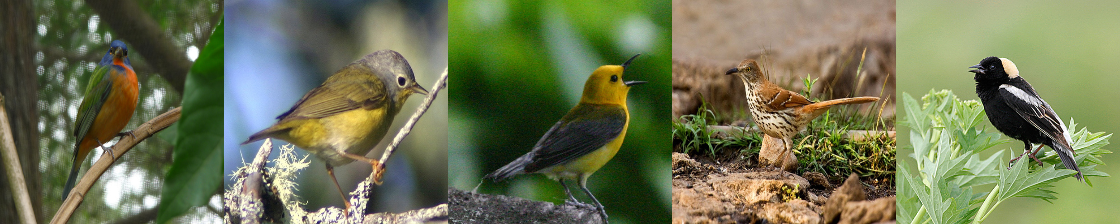

In [118]:
images = get_random_images()

Image.fromarray(np.hstack(list(map(lambda path: get_processed_images(path)[0], images))))

In [274]:
image_grads = get_image_grads(images,
                              model_name='vitb16',
                              pretrain_scheme='base',
                              res=224,
                              num_classes=class_dict['birds'])


['train_model_74']
Loading model from experiments/vitb16_base_224/train_model_74
Loaded vitb16_base_224


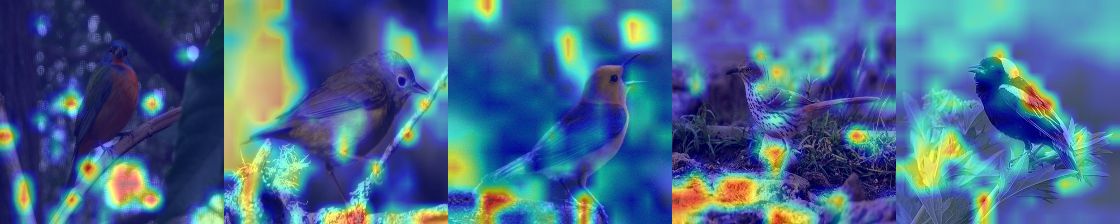

In [275]:
Image.fromarray(np.hstack(image_grads))

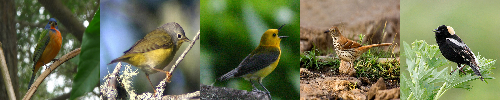

In [122]:
Image.fromarray(np.hstack(list(map(lambda path: get_processed_images(path, 100)[0], images))))

In [121]:
images

['data/CUB_200_2011/images/016.Painted_Bunting/Painted_Bunting_0099_16525.jpg',
 'data/CUB_200_2011/images/172.Nashville_Warbler/Nashville_Warbler_0110_167268.jpg',
 'data/CUB_200_2011/images/177.Prothonotary_Warbler/Prothonotary_Warbler_0127_174149.jpg',
 'data/CUB_200_2011/images/149.Brown_Thrasher/Brown_Thrasher_0130_155350.jpg',
 'data/CUB_200_2011/images/013.Bobolink/Bobolink_0039_9779.jpg']